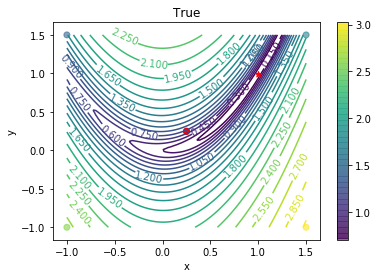

C:\Users\josh\Anaconda3\envs\compute\lib\site-packages\ipykernel_launcher.py:231: RuntimeWarning: divide by zero encountered in log


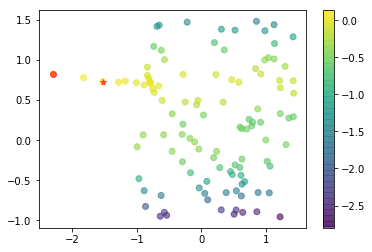

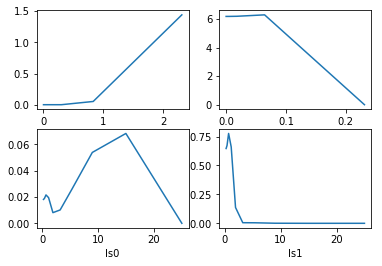

[-2.29592366  0.82563667] 3.29883439191 0.708772688632


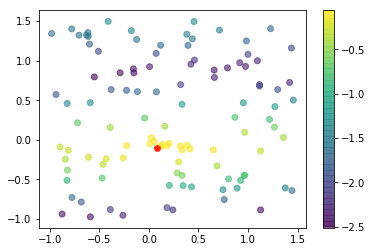

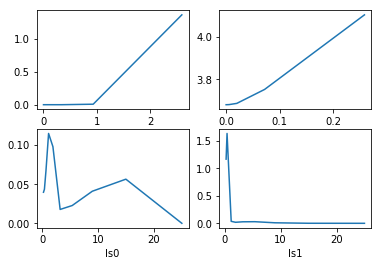

[ 0.08391827 -0.10271826] 0.472757027686 0.472757027686


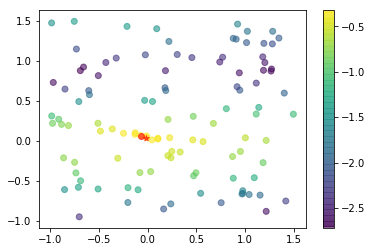

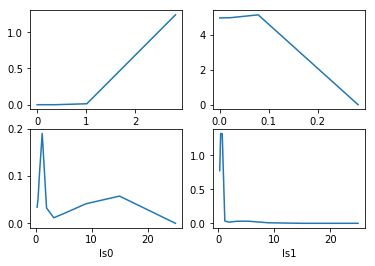

[-0.07001652  0.06539462] 0.393343155315 0.393343155315


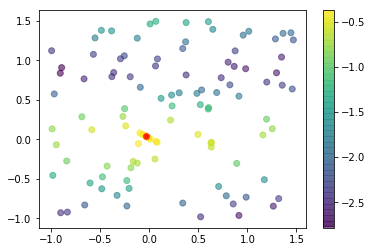

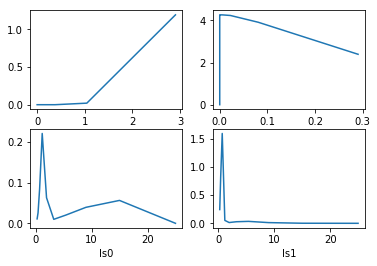

[-0.03598892  0.03532193] 0.345579472613 0.345579472613


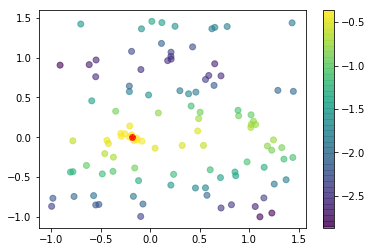

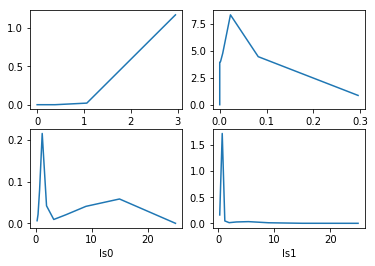

[-0.18152734  0.00731521] 0.375463821723 0.345579472613


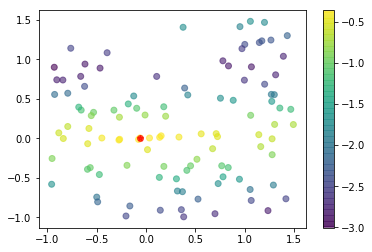

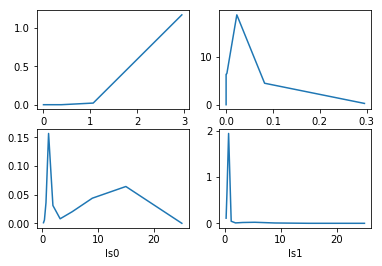

[-0.05992233  0.00555822] 0.331902086536 0.331902086536


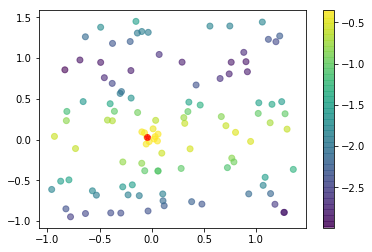

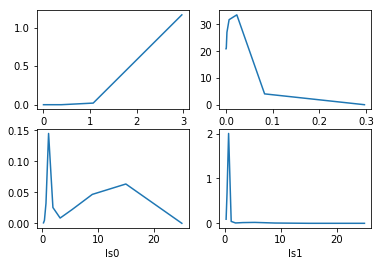

[-0.04794938  0.02916129] 0.332683522338 0.331902086536


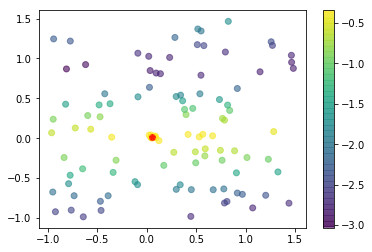

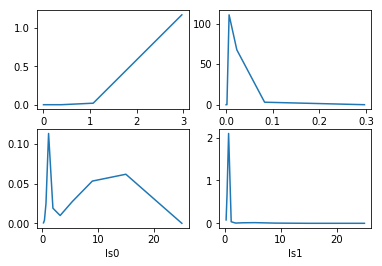

[ 0.05431542  0.01426432] 0.285475637046 0.285475637046


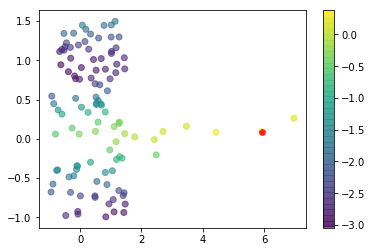

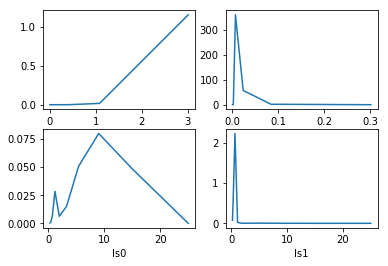

[ 5.93012823  0.09216559] 5.10672023354 0.285475637046


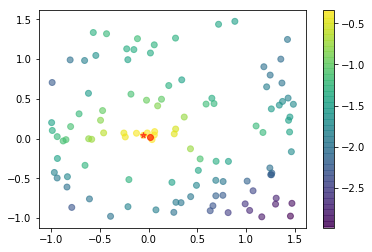

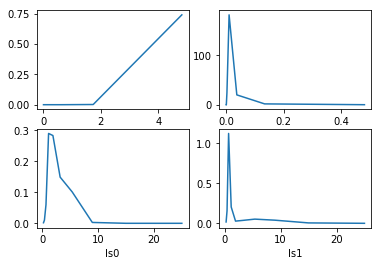

[ 0.0190376  0.0144171] 0.313981363914 0.285475637046


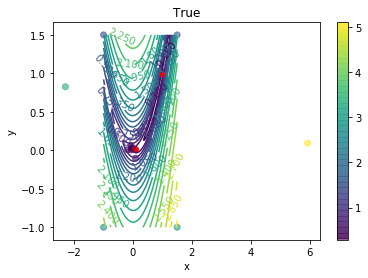

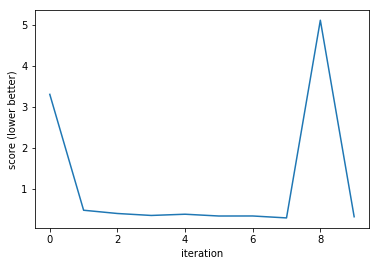

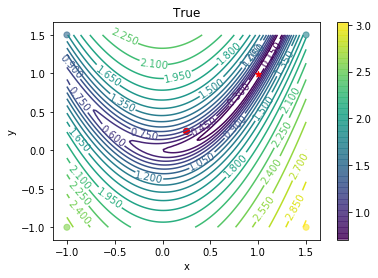

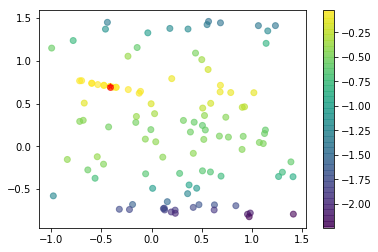

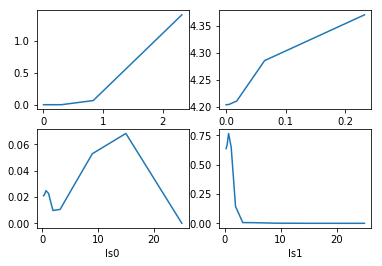

[-0.4141866   0.69897664] 1.48648397158 0.705800209559


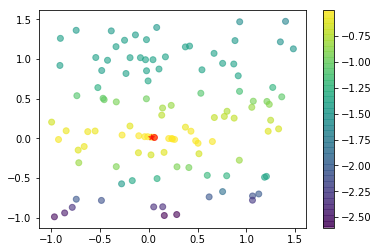

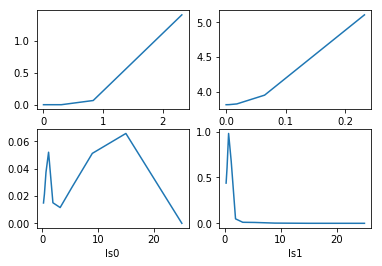

[ 0.05278727  0.01302748] 0.271393453012 0.271393453012


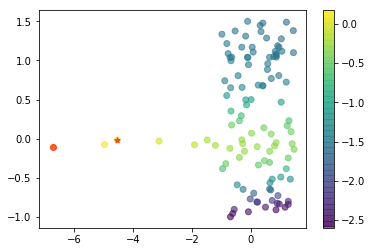

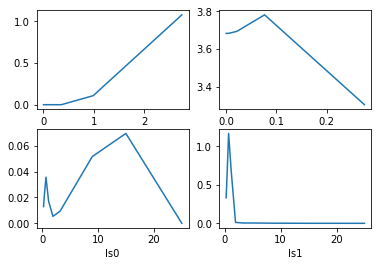

[-6.72220227 -0.10532233] 5.30953614547 0.271393453012


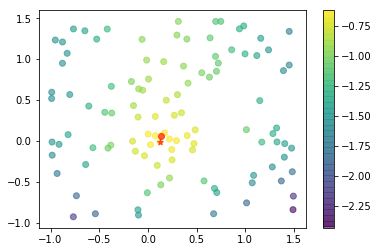

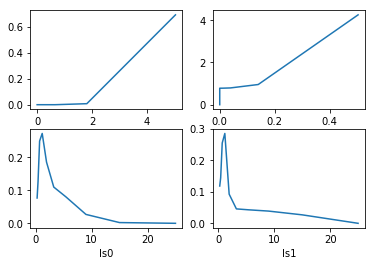

[ 0.13601552  0.0637324 ] 0.296865225855 0.271393453012


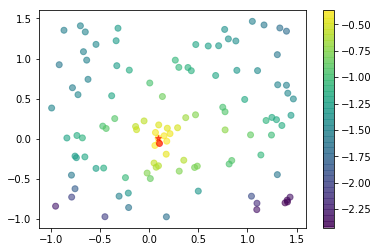

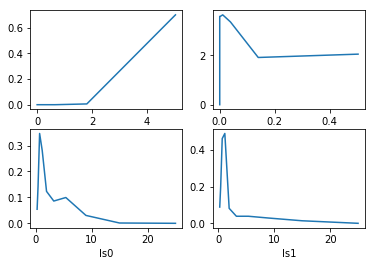

[ 0.09724563 -0.04584099] 0.319471645107 0.271393453012


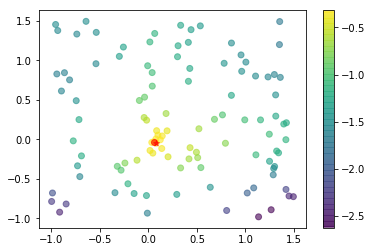

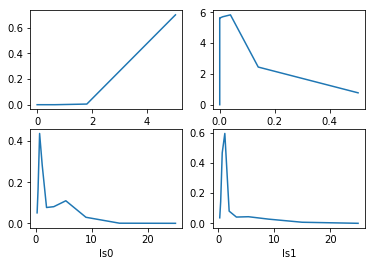

[ 0.056667  -0.0313475] 0.316235655655 0.271393453012


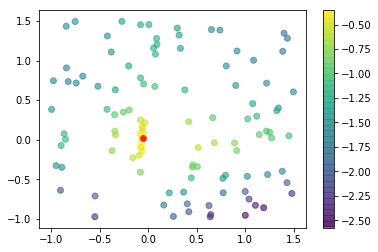

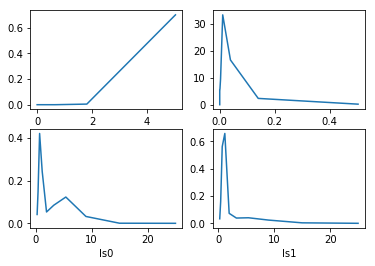

[-0.05886073  0.02435969] 0.325602474876 0.271393453012


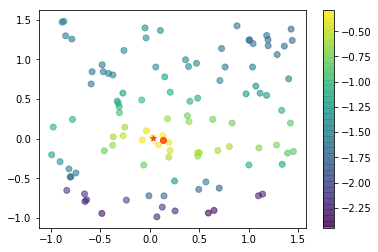

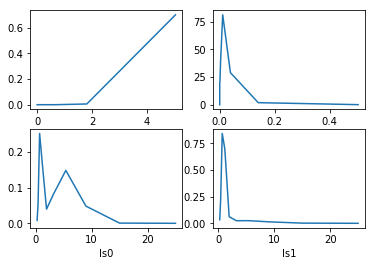

[ 0.13601384 -0.01231916] 0.268663177058 0.268663177058


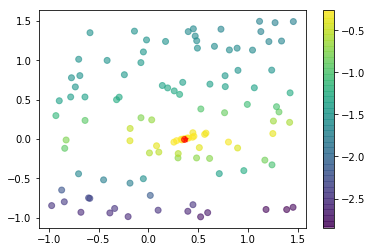

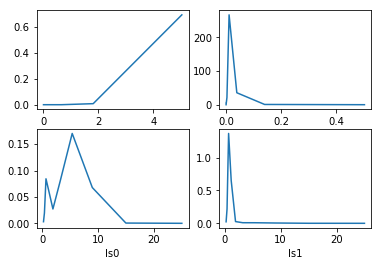

[  3.53012903e-01   1.03028065e-04] 0.485683348715 0.268663177058


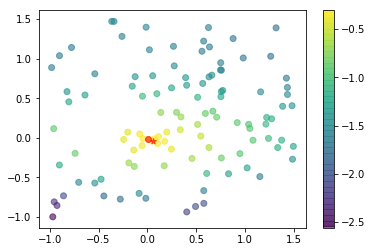

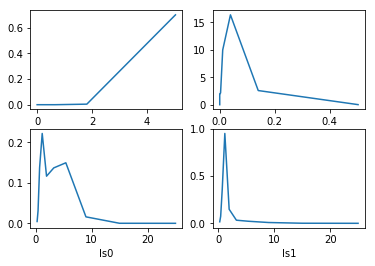

[ 0.01083388 -0.0189729 ] 0.309082201821 0.268663177058


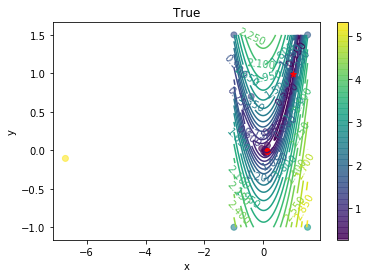

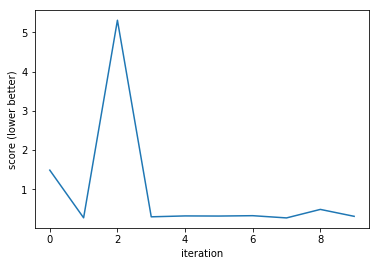

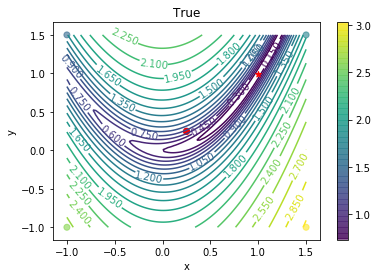

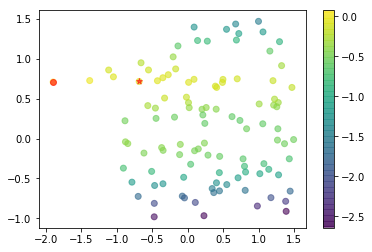

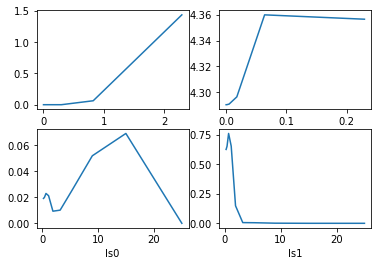

[-1.89969493  0.70921437] 2.91975951101 0.731545507548


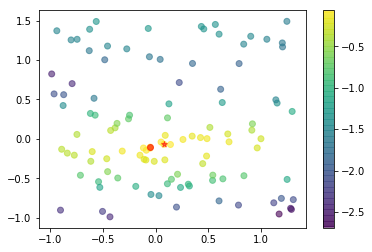

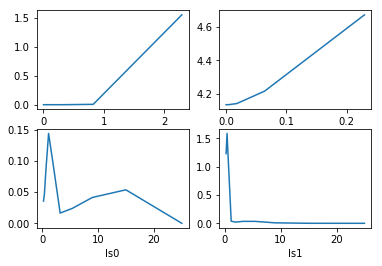

[-0.05224309 -0.10461731] 0.522858743186 0.522858743186


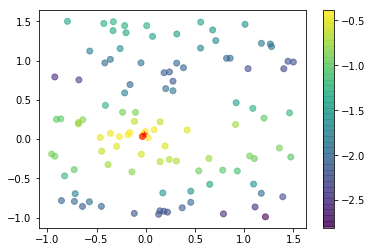

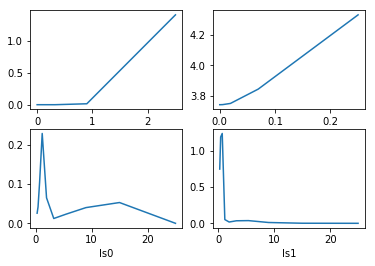

[-0.03741919  0.03847358] 0.345531806408 0.345531806408


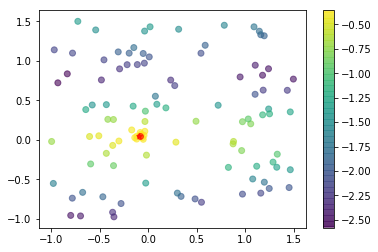

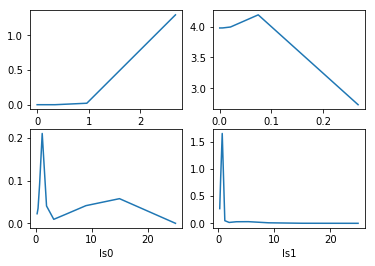

[-0.08596859  0.05124599] 0.383681806307 0.345531806408


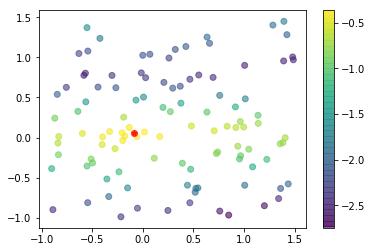

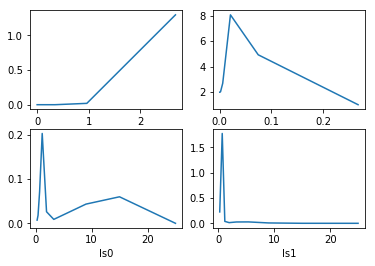

[-0.08687184  0.05353585] 0.378558520004 0.345531806408


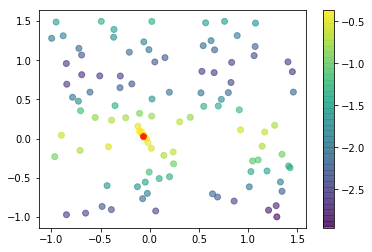

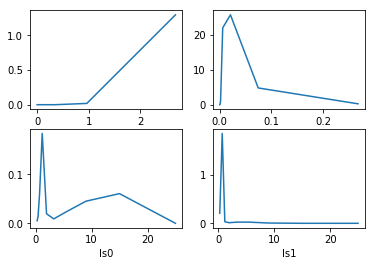

[-0.07064278  0.0397348 ] 0.355001547347 0.345531806408


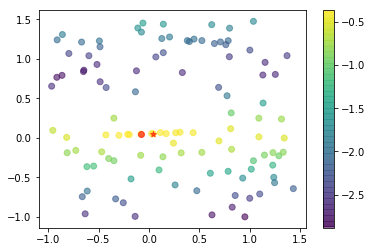

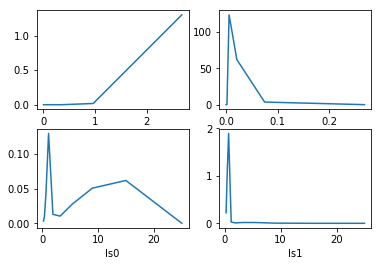

[-0.07889885  0.046794  ] 0.377815030474 0.345531806408


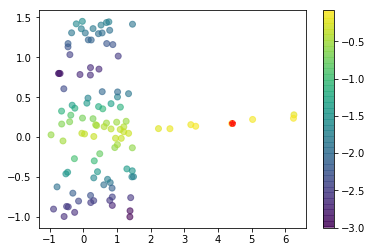

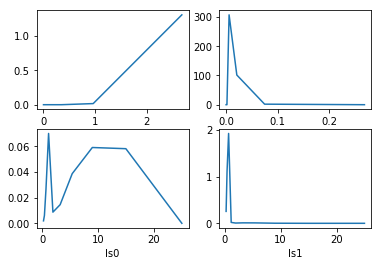

[ 4.40862269  0.17026851] 4.56695955373 0.345531806408


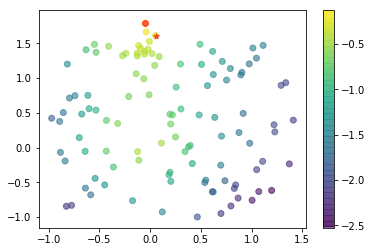

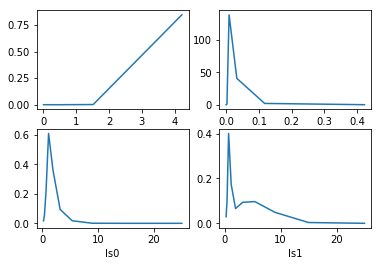

[-0.04872869  1.79054449] 2.51201011098 0.345531806408


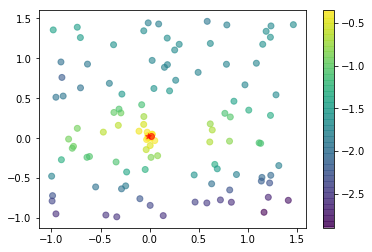

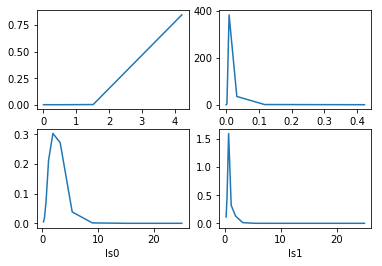

[ 0.01135094  0.03310388] 0.313642546885 0.313642546885


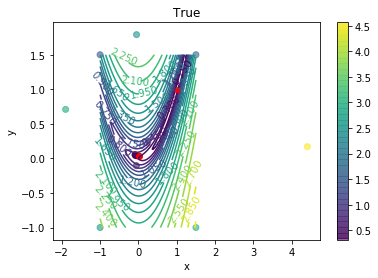

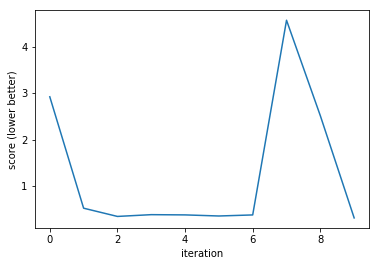

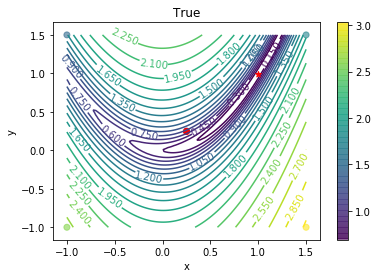

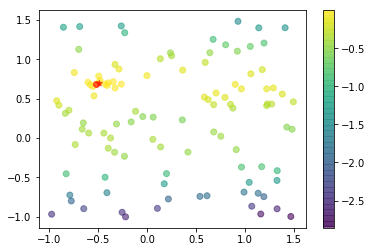

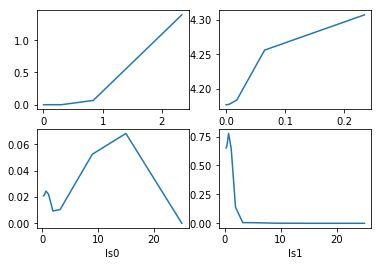

[-0.52002646  0.68357647] 1.32571632325 0.689076147849


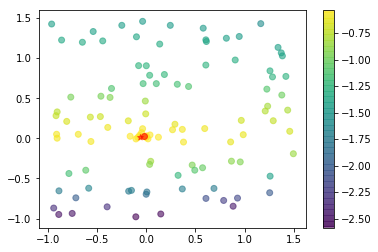

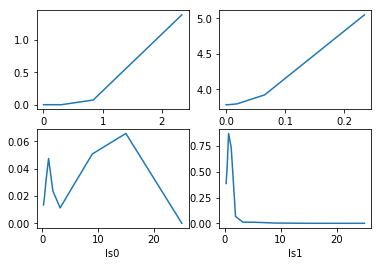

[-0.01967009  0.02547152] 0.307370707858 0.307370707858


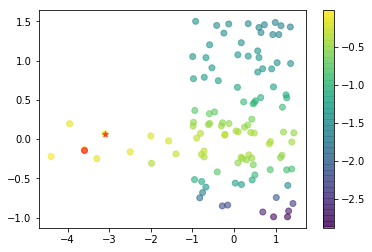

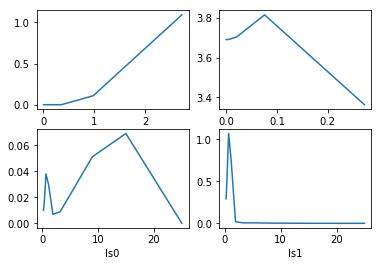

[-3.59849873 -0.13363262] 4.23869328953 0.307370707858


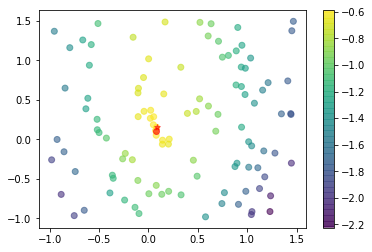

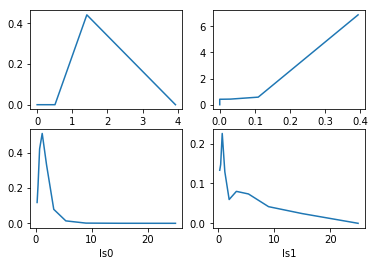

[ 0.07190566  0.10924399] 0.470992151157 0.307370707858


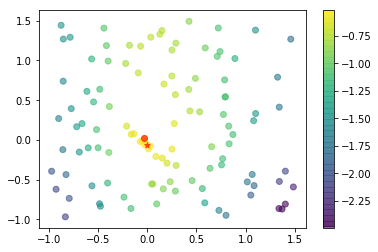

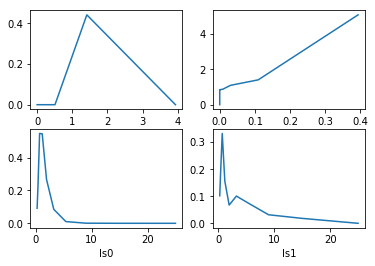

[-0.02768271  0.02249176] 0.327862360579 0.307370707858


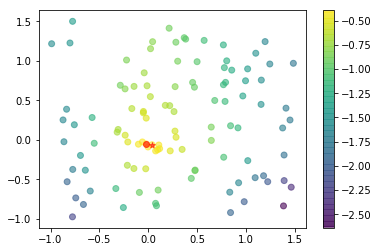

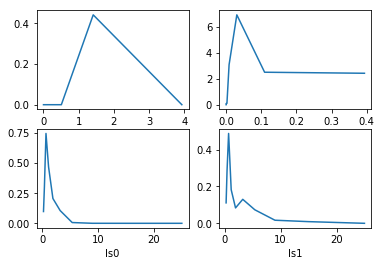

[-0.02094335 -0.05235961] 0.380310448112 0.307370707858


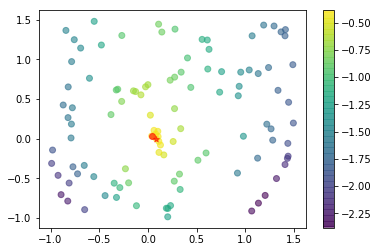

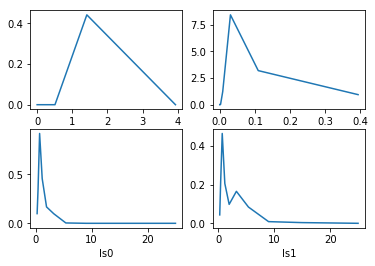

[ 0.03833875  0.03327991] 0.302707949177 0.302707949177


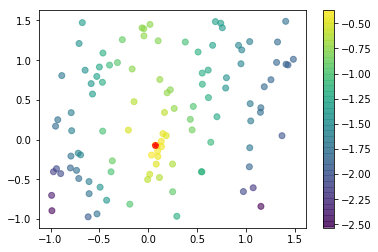

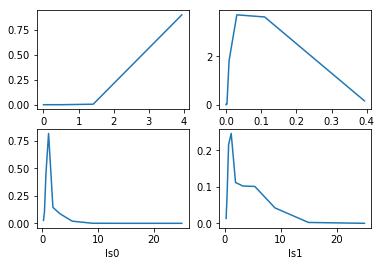

[ 0.07126442 -0.07086148] 0.388304036245 0.302707949177


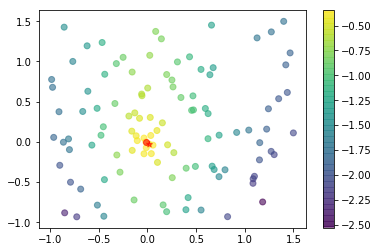

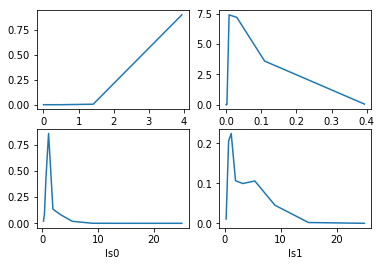

[-0.01625321 -0.00200399] 0.305345832675 0.302707949177


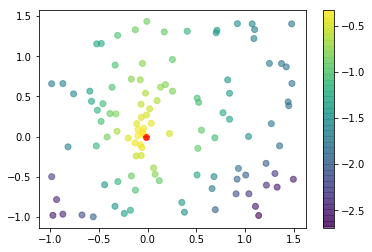

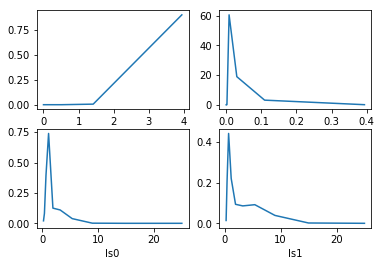

[-0.01516122 -0.0057043 ] 0.310190476646 0.302707949177


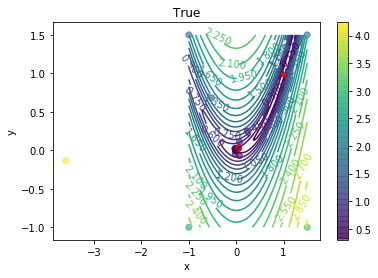

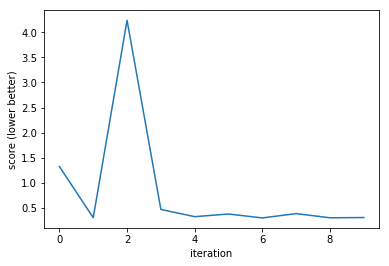

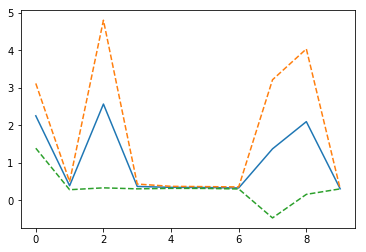

In [1]:
import numpy as np
import pylab as plt
from scipy.special import erf
from scipy.integrate import simps
from ProgressBarClass import ProgressBar
from ChoSolver import choSolve, choBackSubstitution

def styblinsky(x):
    return (x[0]**4 - 16*x[0]**2 + 5*x[0] + x[1]**4 - 16*x[1]**2 + 5*x[1])/2.

def rosenbrock(x):
    a = 1
    b = 100
    return (a-x[0])**2 + b*(x[1] - x[0]**2)**2

def complexInjunction(x):
    Nm = len(x)
    a = np.arange(Nm)
    A = np.outer(np.cos(np.arange(Nm)),np.sin(1j*np.arange(Nm))-Nm)
    y = np.exp(1j*A.dot(x))
    return -np.abs((np.min(y)/np.max(y)).real) 
    
def mean(x):
    #return styblinsky(x)
    return np.log10(1+rosenbrock(x))# + rosenbrock((x-1))
    return np.sqrt((x[0]-0.5)**2 + (x[1])**2)


def M52(XX,theta):
    theta0 = theta[0]
    nu = theta[1]
    lengthScales = theta[2:]
    N = XX.shape[0]
    r2 = np.zeros([N,N],dtype=np.double)
    K = np.zeros([N,N],dtype=np.double)
    i = 0
    while i < len(lengthScales):
        r2 += (XX[:,i,:,i]/lengthScales[i])**2
        i += 1
    K += r2*(5./3.)
    np.sqrt(5*r2,out=r2)
    K += 1+r2
    np.exp(-r2,out=r2)
    K *= r2
    K *= theta0
    return K

def expK(XX,theta):
    theta0 = theta[0]
    nu = theta[1]
    lengthScales = theta[2:]
    N = XX.shape[0]
    K = np.zeros([N,N],dtype=np.double)
    i = 0
    while i < len(lengthScales):
        K -= (XX[:,i,:,i]/lengthScales[i])**2
        i += 1
    K /= 2.
    np.exp(K,out=K)
    K *= theta0
    #K += nu**2*np.eye(N)
    return K

def expK_derivative(XX,theta):
    theta0 = theta[0]
    nu = theta[1]
    lengthScales = theta[2:]
    N = XX.shape[0]
    Kdiff = np.zeros([N,N,len(theta)],dtype=np.double)
    K = np.zeros([N,N],dtype=np.double)
    #0 -> exp(-r^2)
    #1 -> 2*eye(N)*nu
    #2: ->-2r*eye(-r^2)*-2*(x1[i]-x2[i])^2/(lengthScale[i])^3
    i = 0
    while i < len(lengthScales):
        Kdiff[:,:,0] -= (XX[:,i,:,i]/lengthScales[i])**2
        Kdiff[:,:,2+i] += 4*XX[:,i,:,i]**2/lengthScales[i]**3
        i += 1
    #*r
    #np.rollaxis(K[:,:,2:],2,0) *= np.sqrt(-Kdiff[:,:,0])
    K /= 2.
    np.exp(K,out=K)
    K *= theta0
    K += nu**2*np.eye(N)
    return K

class Prior(object):
    def __init__(self, **kwargs):
        for key in kwargs.keys():
            setattr(self,key,kwargs[key])
    def domain(self):
        '''Get domain of prior'''
        return None
    def sample(self,N=1):
        '''get a sample from the distribution'''
        return None
    def pdf(self,x):
        '''get the pdf at x'''
        return None

class UniformPrior(Prior):
    def __init__(self,xmin,xmax):
        d = {"xmin":float(min(xmin,xmax)),"xmax":float(max(xmin,xmax)),"width":float(max(xmin,xmax) - min(xmin,xmax))}
        super(UniformPrior,self).__init__(**d)
    def sample(self,N=1):
        return np.random.uniform(low=self.xmin,high=self.xmax,size=N)
    def pdf(self,x):
        out = np.ones_like(x)
        out /= self.width
        out[x>self.xmax] *= 0.
        out[x<self.xmin] *= 0.
        return out
    
class NormalPrior(Prior):
    def __init__(self,mean,std):
        d = {"mean":float(mean),"std":float(std)}
        super(NormalPrior,self).__init__(**d)
    def sample(self,N=1):
        return self.mean + self.std*np.random.normal(size=N)
    def pdf(self,x):
        return np.exp(-(x - self.mean)**2/self.std**2/2.)/np.sqrt(2*np.pi)/self.std

class LogNormalPrior(Prior):
    def __init__(self,mean,std):
        d = {"mean":float(mean),"std":float(std)}
        super(LogNormalPrior,self).__init__(**d)
    def sample(self,N=1):
        return np.random.lognormal(mean=self.mean, sigma=self.std, size=N)
    def pdf(self,x):
        return np.exp(-(np.log(x) - self.mean)**2/self.std**2/2.)/np.sqrt(2*np.pi)/self.std/x

class ClassPrior(Prior):
    def __init__(self,numClasses,weights=None):
        if weights is None:
            weights = np.ones(numClasses,dtype=np.double)/numClasses
        d = {"numClasses":float(numClasses),"weights":float(weights)}
        super(ClassPrior,self).__init__(**d)
    def sample(self,N=1):
        samples = np.zeros(N,dtype=np.int64)
        i = 0
        while i < N:
            c = -1
            while c == -1:    
                c_ = np.random.randint(self.numClasses)
                if np.random.uniform() < self.weights[c_]:
                    c = c_
            samples[i] = c
            i += 1            
        return samples
    def pdf(self,x):
        return self.weights[np.int64(x)]
    
class DiscretePrior(Prior):
    def __init__(self,values,prior=None):
        if prior is None:
            prior = UniformPrior(np.min(values),np.max(values))
        d = {"values":values,"prior":prior}
        super(DiscretePrior,self).__init__(**d)
    def sample(self,N=1):
        samples = np.zeros(N,dtype=np.int64)
        i = 0
        while i < N:
            c = -1
            while c == -1:    
                c_ = np.random.randint(len(self.values))
                if np.random.uniform() < self.prior.pdf(self.values[c_]):
                    c = c_
            samples[i] = self.values[c]
            i += 1            
        return samples
    def pdf(self,x):
        return self.prior.pdf(x)
    
if __name__ == '__main__':
    def sampleX(xPriors,N):
        X = np.zeros([N,len(xPriors)],dtype=np.double)
        for i in range(len(xPriors)):
            X[:,i] = xPriors[i].sample(N)
        return X
    
    def computeAquisition(Xstar,X,y,thetaPriors,iteration=1):
        Xstar = np.atleast_2d(Xstar)
        shape = []
        indices = []
        for thetaPrior in thetaPriors:
            ar = thetaPrior.values
            shape.append(len(ar))
            indices.append(np.arange(len(ar)))
        n = len(thetaPriors)
        postTheta = np.zeros(shape,dtype=np.double)
        COMP = np.zeros(shape,dtype=np.double)
        DF = np.zeros(shape,dtype=np.double)
        LML = np.zeros(shape,dtype=np.double)
        Xboth = np.vstack([X,Xstar])
        XXboth = np.subtract.outer(Xboth,Xboth)
        arg = np.argsort(y)
        xbest = X[arg[0],:]
        fbest = y[arg[0]]
        aq_full = np.zeros([Xstar.shape[0]]+shape,dtype=np.double)
        for idx in product(*indices):
            theta = np.zeros(len(indices),dtype=np.double)
            for i in range(len(idx)):
                theta[i] = thetaPriors[i].values[idx[i]]
            nu = theta[1]
            #Kboth = expK(XXboth,theta)
            Kboth = M52(XXboth,theta)
            K00 = Kboth[0:X.shape[0],0:X.shape[0]] 
            K00 += nu**2*np.eye(X.shape[0])
            K01 = Kboth[0:X.shape[0],X.shape[0]:]
            K10 = K01.T
            K11 = Kboth[X.shape[0]:,X.shape[0]:]
            L = np.linalg.cholesky(K00)
            alpha = choSolve(L,y,False)
            #mu[j] = sum_i alpha[i]K01[i,j]
            mu = K10.dot(alpha)
            #cov = K11 - K10.(K00+sigma)(^-1).K01
            V = choBackSubstitution(L,K01,True,False)
            std = np.sqrt(np.diag(K11 - V.T.dot(V)))
            gamma = (fbest - mu)/std
            #POI
            cum = (1 + erf(gamma/np.sqrt(2)))/2.
            #return
            #EI
            aq = std*(gamma*cum + np.exp(-gamma**2/2)/np.sqrt(2*np.pi))
            #aq = (1./(iteration+1))*std - mu
            datafit = -y.dot(alpha)/2.
            complexity = np.sum(np.log(np.diag(L)))
            marLik = np.exp(datafit - complexity  - np.log(2*np.pi)*n/2.)
            COMP[idx] = complexity
            DF[idx] = datafit
            LML[idx] = np.log(marLik)
            prior = 1.
            for t,tp in zip(theta,thetaPriors):
                prior  *= tp.pdf(t)    
            postTheta[idx] = marLik * prior 
            aq_full[ [slice(0,Xstar.shape[0])]+list(idx)] = aq*postTheta[idx]
        prob = np.copy(postTheta)
        for axis in range(len(thetaPriors)):
            aq_full = simps(aq_full,thetaPriors[len(thetaPriors)-axis-1].values,axis=len(thetaPriors)-axis)
            prob = simps(prob,thetaPriors[len(thetaPriors)-axis-1].values,axis=len(thetaPriors)-axis-1)
        aq_full /= prob
        postTheta /= prob
        return aq_full,postTheta

    def maximizeAquisition(xPriors,X,y,thetaPriors=None,iteration=0):
        '''Using gradient (or steepest if desired) maximize the Expected Improvment aquisition
        while integration over aquisition hyper parameters.
        '''
        if thetaPriors is None:
            #Set up thetaPriors
            res = 10
            #theta0 ~ max(y) - min(y), uniform, log spacing 4 mag
            m2 = np.max(y) - np.min(y)
            m1 = m2/1e4
            theta0Prior = DiscretePrior(10**np.linspace(np.log10(m1),np.log10(m2),res),
                                   prior=UniformPrior(m1,m2))
            # nu ~ obs noise. similarly but scaled down by 10%
            m2 = (np.max(y) - np.min(y))/10.
            m1 = (m2/1e4)/10.
            nuPrior = DiscretePrior(10**np.linspace(np.log10(m1),np.log10(m2),res),
                                   prior=UniformPrior(m1,m2))
            thetaPriors = [theta0Prior,nuPrior]
            for i in range(len(xPriors)):
                #handles uniform x priors right now
                m2 = (xPriors[i].xmax - xPriors[i].xmin)*10.
                m1 = (xPriors[i].xmax - xPriors[i].xmin)/10.
                lsPrior = DiscretePrior(10**np.linspace(np.log10(m1),np.log10(m2),res),
                                   prior=UniformPrior(m1,m2))
                thetaPriors.append(lsPrior)
        for thetaPrior in thetaPriors:
            assert isinstance(thetaPrior,DiscretePrior), "one theta prior is not discrete"
        from itertools import product
        #First sample points to initialize maximization
        #create aquisition at x
        Xstar = sampleX(xPriors,max(2,len(thetaPriors))**max(2,len(xPriors)))
        Xstar = sampleX(xPriors,10**max(2,len(xPriors)))
        arg = np.argsort(y)
        xbest = X[arg[0],:]
        fbest = y[arg[0]]
        aq_all = []
        Xstar_all = []
        N = len(y)
        aq_init,postTheta = computeAquisition(Xstar,X,y,thetaPriors,iteration)
        aq_all.append(aq_init)
        Xstar_all.append(Xstar)
        arg = np.argsort(aq_init)
        Xsimp = Xstar[arg[-len(xPriors)-1:],:]
        aq_simp = aq_init[arg[-len(xPriors)-1:]]
        #min to max
        alpha,gamma,rho,sigma = 1.,2.,0.5,0.5
        iter = 0
        NonCovergent = True
        while NonCovergent:
            if iter >= 5:
                break
            iter += 1
            #order for min (flip aq sign)
            arg = np.argsort(-aq_simp)
            aq_simp = aq_simp[arg]
            Xsimp = Xsimp[arg,:]
            #print(Xsimp,aq_simp)
            #centorid except last
            x0 = np.mean(Xsimp[:-1,:],axis=0)
            #reflection
            xr = x0 + alpha*(x0 - Xsimp[-1,:])
            aq_r,postTheta = computeAquisition(xr,X,y,thetaPriors,iteration)
            #print(xr,aq_r)
            aq_all.append(aq_r)
            Xstar_all.append(xr)
            if -aq_simp[0] <= -aq_r and -aq_r < -aq_simp[-2]:
                Xsimp[-1,:] = xr
                aq_simp[-1] = aq_r
                continue
            #expansion
            if -aq_r < -aq_simp[0]:
                xe = x0 + gamma*(xr - x0)
                aq_e,postTheta = computeAquisition(xe,X,y,thetaPriors,iteration)
                aq_all.append(aq_e)
                Xstar_all.append(xe)
                if -aq_e < -aq_r:
                    Xsimp[-1,:] = xe
                    aq_simp[-1] = aq_e
                    continue
                else:
                    Xsimp[-1,:] = xr
                    aq_simp[-1] = aq_r
                    continue
            #contractions
            xc = x0 + rho*(Xsimp[-1,:] - x0)
            aq_c,postTheta = computeAquisition(xc,X,y,thetaPriors,iteration)
            aq_all.append(aq_c)
            Xstar_all.append(xc)
            if -aq_c < -aq_simp[-1]:
                Xsimp[-1,:] = xc
                aq_simp[-1] = aq_c
                continue
            #shrink
            for i in range(Xsimp.shape[0]):
                Xsimp[i,:] = Xsimp[0,:] + sigma*(Xsimp[i,:] - Xsimp[0,:])        
        xbest_nm = Xsimp[0,:]
        #print(xbest_nm)
        aq_all = np.hstack(aq_all)
        Xstar = np.vstack(Xstar_all)
        arg = np.argsort(aq_all)
        xbest = Xstar[arg[-1],:]
        if True:    
            vmin = np.min(aq_all)
            vmax = np.max(aq_all)
            plt.figure()
            sc=plt.scatter(Xstar[:,0],Xstar[:,1],c=aq_all,
                           vmin=vmin,vmax=vmax,alpha=0.6)
            plt.scatter(xbest[0],xbest[1],c='red',alpha=0.6)
            plt.scatter(xbest_nm[0],xbest_nm[1],c='red',marker='*',alpha=0.6)
            plt.colorbar(sc)
            plt.show() 
            fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
            ax1.plot(thetaPriors[0].values,
                    simps(simps(simps(postTheta,thetaPriors[3].values,axis=3),
                          thetaPriors[2].values,axis=2),
                           thetaPriors[1].values,axis=1))
            ax1.set_xlabel("theta0")
            ax2.plot(thetaPriors[1].values,
                    simps(simps(simps(postTheta,thetaPriors[3].values,axis=3),
                          thetaPriors[2].values,axis=2),
                           thetaPriors[0].values,axis=0))
            ax2.set_xlabel("nu")
            ax3.plot(thetaPriors[2].values,
                    simps(simps(simps(postTheta,thetaPriors[3].values,axis=3),
                          thetaPriors[1].values,axis=1),
                           thetaPriors[0].values,axis=0))
            ax3.set_xlabel("ls0")
            ax4.plot(thetaPriors[3].values,
                    simps(simps(simps(postTheta,thetaPriors[2].values,axis=2),
                          thetaPriors[1].values,axis=1),
                           thetaPriors[0].values,axis=0))
            ax4.set_xlabel("ls1")
            plt.show()         
        return xbest
        
    #Set up data
    np.random.seed(12344)
    nu = 0.01
    xPriors = [UniformPrior(-1,1.5),
               UniformPrior(-1,1.5)]
    thetaPriors = [DiscretePrior(10**np.linspace(np.log10(0.1),np.log10(5),10),prior=UniformPrior(0,5)),
                   DiscretePrior(10**np.linspace(np.log10(0.001),np.log10(0.5),10),prior=LogNormalPrior(np.log(0.1),np.log(0.5/0.01))),
                   DiscretePrior(np.linspace(0.5,6,10),prior=LogNormalPrior(np.log(1),np.log(6/0.5))),
                   DiscretePrior(np.linspace(0.5,6,10),prior=LogNormalPrior(np.log(1),np.log(6/0.5)))]
    
    X,Y = np.meshgrid(np.linspace(xPriors[0].xmin,xPriors[0].xmax,100),
                         np.linspace(xPriors[1].xmin,xPriors[1].xmax,100),
                     indexing='ij')
    A = []
    for x,y in zip(X.flatten(),Y.flatten()):
        A.append(mean(np.array([x,y])))
    Niter = 10
    minidx = np.zeros([4,Niter],dtype=np.double)
    for r in range(4):
        score = []
        #plt.figure()
        c1 = plt.contour(X,Y,np.array(A).reshape(X.shape),20)
        plt.clabel(c1,inline=1,fontsize=10)
        plt.title("True")
        plt.xlabel("x")
        plt.ylabel("y")
        arg = np.argsort(A)
        plt.scatter(X.flatten()[arg[0]],Y.flatten()[arg[0]],zorder=20,c='red',marker='*',alpha=1)
        #sample corners and center
        xCorners = []
        for xPrior in xPriors:
            xCorners.append([xPrior.xmin,xPrior.xmax])
        from itertools import product
        Xdata = []
        y = []
        for x in product(*xCorners):
            Xdata.append(np.array(x))
            y.append(mean(Xdata[-1]) + nu*np.random.normal())
        Xdata.append(np.mean(np.array(xCorners),axis=1))
        y.append(mean(Xdata[-1]) + nu*np.random.normal())
        Xdata = np.array(Xdata)
        y = np.array(y) 
        sc=plt.scatter(Xdata[:,0],Xdata[:,1],c=y,vmin=np.min(y),vmax=np.max(y),alpha=0.6)
        arg = np.argsort(y)
        plt.scatter(Xdata[arg[0],0],Xdata[arg[0],1],c='red',vmin=np.min(y),vmax=np.max(y),alpha=1)
        plt.colorbar(sc)
        plt.show() 
        #do iterations to find min
        arg = np.argsort(y) 
        fbest = y[arg[0]]
        xprev = Xdata[arg[0]]
        i = 0
        while i < Niter:
            #do gradient decent to find max of full aquisition
            xnext = maximizeAquisition(xPriors,Xdata,y,thetaPriors=None,iteration=i)
            xprev = xnext
            #print(y)
            f = mean(xnext) + nu*np.random.normal()
            Xdata = np.vstack([Xdata,xnext])
            y = np.hstack([y,f])
            fbest = np.min(y)
            score.append(f)
            print(xnext,f,fbest)
            i += 1
        c1 = plt.contour(X,Y,np.array(A).reshape(X.shape),20)
        plt.clabel(c1,inline=1,fontsize=10)
        plt.title("True")
        plt.xlabel("x")
        plt.ylabel("y")
        arg = np.argsort(A)
        plt.scatter(X.flatten()[arg[0]],Y.flatten()[arg[0]],zorder=20,c='red',marker='*',alpha=1)
        sc=plt.scatter(Xdata[:,0],Xdata[:,1],c=y,vmin=np.min(y),vmax=np.max(y),alpha=0.6)
        arg = np.argsort(y)
        plt.scatter(Xdata[arg[0],0],Xdata[arg[0],1],c='red',vmin=np.min(y),vmax=np.max(y),alpha=1)
        plt.colorbar(sc)
        plt.show() 
        plt.plot(score)
        plt.ylabel('score (lower better)')
        plt.xlabel("iteration")
        plt.show()
        minidx[r,:] = score
    plt.plot(np.mean(minidx,axis=0))
    plt.plot(np.mean(minidx,axis=0)+np.std(minidx,axis=0),ls='--')
    plt.plot(np.mean(minidx,axis=0)-np.std(minidx,axis=0),ls='--')
    plt.show()
        
    
    

2

In [9]:
import numpy as np
a = np.ones(4)
print(a)
print(np.atleast_2d(a).shape)

[ 1.  1.  1.  1.]
(1, 4)


In [6]:
print(7/3. - 4./3. -1, 4/3.-1/3.-1,1-2./3-1./3)

2.220446049250313e-16 0.0 5.551115123125783e-17


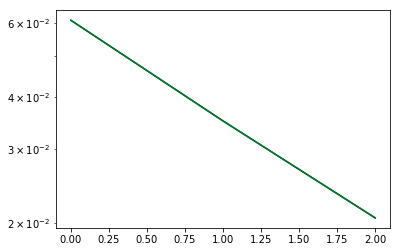

0.002433823805404245
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
ERROR: Could not find file <ipython-input-78-4dedb1ffe335>
NOTE: %mprun can only be used on functions defined in physical files, and not in the IPython environment.

0.0352368383337307


In [78]:
def int3points(x1,x2,x3,y1,y2,y3):
    x0 = 1/x1
    x4 = 1/x2
    x5 = x3**2
    x6 = x0*x5
    x7 = 1/(-x0*x3 - x3*x4 + x4*x6 + 1)
    x8 = x1 - x2
    x9 = 1/x8
    x10 = x3 - x6
    x11 = x1*x10*x4*x7*x9
    x12 = x1**2
    x13 = 1/x12
    x14 = x2*x9
    x15 = x0*x14
    x16 = x7*(x10*x15 - x13*x5)
    x17 = -x11*y2 + x16*y1 + x7*y3
    x18 = x2**2
    x19 = -x13*x18 + 1
    x20 = x4*x9
    x21 = -x1*x19*x4*x7*x9*y3/2 + y1*(-x1*x16*x19*x4*x9 - x15)/2 + y2*(x1*x20 + x10*x12*x19*x7/(x18*x8**2))/2
    x22 = x13 - x19*x20
    x23 = -x22*x7*y3/3 + y1*(x13*x14 + x13 - x16*x22)/3 + y2*(x11*x22 - x20)/3
    return -x1**3*x23 - x1*x17 - x12*x21 + x17*x3 + x21*x5 + x23*x3**3

def simps(y,x,axis=None):
    assert len(x) == len(y), "sizes of x and y not same {} an {}".format(len(x),len(y))
    assert len(x) >= 4, "not enough points to integrate only {}".format(len(x))
    #arg = np.argsort(x)
    #x = x[arg]
    #y = y[arg]
    #generate the X1,X2,X3
    X1 = x[0:len(x)-2]
    X2 = x[1:len(x)-1]
    X3 = x[2:len(x)]
    Y1 = y[0:len(x)-2]
    Y2 = y[1:len(x)-1]
    Y3 = y[2:len(x)]
    I = int3points(X1,X2,X3,Y1,Y2,Y3)
    #out = (np.sum(I) + (x[1] - x[0])/(x[2] - x[0])*I[0] + (x[-1] - x[-2])/(x[-1] - x[-3])*I[-1])/2.
    out = (np.sum(I) + (x[1] - x[0])*(y[0] + y[1])/2. + (x[-1] - x[-2])*(y[-2] + y[-1])/2.)/2.
    return out

import numpy as np
from scipy.integrate import simps as simps_scipy
import pylab as plt

def f(x):
    return x**2

def g(x):
    return np.exp(-(x - 0.5)**2)#/np.sqrt(2*np.pi)

error1 = []
error2 = []
for i in range(4,10,2):
    x = 10**np.linspace(np.log10(0.001),np.log10(1),i)
    #x = np.linspace(0.001,1,i)
    ans = x[-1]**3/3. - x[0]**3/3.
    error1.append(np.abs(simps_scipy(f(x),x) - ans))
    error2.append(np.abs(simps(f(x),x) - ans))

plt.plot(error1,c='blue')
plt.plot(error2,c='green')
plt.yscale('log')
plt.show()
from time import clock
x = 10**np.linspace(np.log10(0.001),np.log10(1),100000)
y = f(x)
t1 = clock()
simps_scipy(y,x)
print(clock() - t1)
%load_ext memory_profiler
%load_ext line_profiler
t1 = clock()
%mprun -f simps simps(y,x)
print(clock() - t1)

In [7]:
import numpy as np

def vertex(x1,x2,x3,y1,y2,y3):
    '''Given three pairs of (x,y) points return the vertex of the
         parabola passing through the points. Vectorized and common expression reduced.'''
    #Define a sequence of sub expressions to reduce redundant flops
    x0 = 1/x2
    x4 = x1 - x2
    x5 = 1/x4
    x6 = x1**2
    x7 = 1/x6
    x8 = x2**2
    x9 = -x7*x8 + 1
    x10 = x0*x1*x5*x9
    x11 = 1/x1
    x12 = x3**2
    x13 = x11*x12
    x14 = 1/(x0*x13 - x0*x3 - x11*x3 + 1)
    x15 = x14*y3
    x16 = x10*x15
    x17 = x0*x5
    x18 = -x13 + x3
    x19 = y2*(x1*x17 + x14*x18*x6*x9/(x4**2*x8))
    x20 = x2*x5
    x21 = x11*x20
    x22 = x14*(-x12*x7 + x18*x21)
    x23 = y1*(-x10*x22 - x21)
    x24 = x16/2 - x19/2 - x23/2
    x25 = -x17*x9 + x7
    x26 = x0*x1*x14*x18*x5
    x27 = 1/(-x15*x25 + y1*(x20*x7 - x22*x25 + x7) + y2*(-x17 + x25*x26))
    x28 = x24*x27
    return x28,x15 + x22*y1 + x24**2*x27 - x26*y2 + x28*(-x16 + x19 + x23)

def coeffs(x1,x2,x3,y1,y2,y3):
    x0 = x1**(-2)
    x4 = 1/(x1 - x2)
    x5 = 1/x2
    x6 = -x0*x2**2 + 1
    x7 = -x0 + x4*x5*x6
    x8 = 1/x1
    x9 = x3*x8
    x10 = -x9
    x11 = x10 + 1
    x12 = 1/(x11 + x3**2*x5*x8 - x3*x5)
    x13 = x12*y3
    x14 = x5*y2
    x15 = x12*x3*x7
    x16 = x2*x8
    x17 = x10 + x11*x2*x4
    x18 = x1*x11*x3*x4*x5
    x19 = x12*x6
    return (x13*x7 - x14*x4*(x1*x11*x15 + 1) + x8*y1*(x15*x17 + x16*x4 + x8),
            x4*(-x1*x13*x5*x6 + x1*x14*(x18*x19 + 1) - y1*(x16 + x17*x19*x3*x5)),
            x12*(x17*x9*y1 - x18*y2 + y3))

def int3points(x1,x2,x3,y1,y2,y3):
    x0 = 1/x1
    x4 = 1/x2
    x5 = x3**2
    x6 = x0*x5
    x7 = 1/(-x0*x3 - x3*x4 + x4*x6 + 1)
    x8 = x1 - x2
    x9 = 1/x8
    x10 = x3 - x6
    x11 = x1*x10*x4*x7*x9
    x12 = x1**2
    x13 = 1/x12
    x14 = x2*x9
    x15 = x0*x14
    x16 = x7*(x10*x15 - x13*x5)
    x17 = -x11*y2 + x16*y1 + x7*y3
    x18 = x2**2
    x19 = -x13*x18 + 1
    x20 = x4*x9
    x21 = -x1*x19*x4*x7*x9*y3/2 + y1*(-x1*x16*x19*x4*x9 - x15)/2 + y2*(x1*x20 + x10*x12*x19*x7/(x18*x8**2))/2
    x22 = x13 - x19*x20
    x23 = -x22*x7*y3/3 + y1*(x13*x14 + x13 - x16*x22)/3 + y2*(x11*x22 - x20)/3
    return -x1**3*x23 - x1*x17 - x12*x21 + x17*x3 + x21*x5 + x23*x3**3

def int4points(x1,x2,x3,x4,y1,y2,y3,y4):
    x0 = 1/x1
    x5 = x0*x4
    x6 = -x5 + 1
    x7 = 1/x2
    x8 = x4*x7
    x9 = 1/x3
    x10 = x4**2
    x11 = x0*x10
    x12 = x7*x9
    x13 = x4**3
    x14 = 1/(-x0*x12*x13 + x10*x12 + x11*x7 + x11*x9 - x4*x9 + x6 - x8)
    x15 = x14*x4
    x16 = x3**2
    x17 = 1/(x1*x2 - x1*x3 + x16 - x2*x3)
    x18 = x1**2
    x19 = 1/x18
    x20 = x10*x19
    x21 = 1/(x1 - x2)
    x22 = x2**2
    x23 = -x19*x22 + 1
    x24 = x21*x23
    x25 = x1*x24*x4*x6*x7
    x26 = x20 + x25 - 1
    x27 = x6*x8
    x28 = x0*x3
    x29 = -x28
    x30 = x29 + 1
    x31 = x1*x3*x30
    x32 = x17*x26*x31 + x27
    x33 = x2*x21
    x34 = x0*x33*x4*x6
    x35 = -x20
    x36 = -x25 + x35 + 1
    x37 = x29 + x30*x33
    x38 = x17*x2*x3*x37
    x39 = x36*x38
    x40 = x1*x17*x2*x26*x4*x9*y3 - x1*x21*x32*x4*x7*y2 - x5*y1*(x20 - x34 + x39) + y4
    x41 = x17*x18
    x42 = x1**3
    x43 = 1/x42
    x44 = (-x2**3*x43 + 1)/x22
    x45 = x21*x44
    x46 = -x1*x16*x30*x45 - x3**3*x43 + 1
    x47 = x17*x31*x36 - x27
    x48 = x14*x4*x46*x9
    x49 = x34 + x35 - x39
    x50 = x1*x14*x2*x46*x9*y4/2 - x1*x2*x9*y3*(x1*x14*x17*x2*x36*x4*x46*x9 + 1)/2 + x18*x21*y2*(x3*x30*x7 + x47*x48)/2 - x2*y1*(x28*x37 - x48*x49)/2
    x51 = x17*x46*x9
    x52 = x1*x23*x51
    x53 = -x44 + x52
    x54 = x44 - x52
    x55 = x14*x36*x4
    x56 = x19*x2
    x57 = x21*(x1*x14*x53*y4 + x1*x7*y2*(-x1*x15*x21*x32*x53 + x21*x23*x3*x30*x41*x7 + x7) - x41*x9*y3*(-x2*x54*x55 + x23) - y1*(x15*x49*x54 + x17*x23*x3*x37 + x56))/3
    x58 = x19 - x24*x7
    x59 = x1*x2*x51*x58
    x60 = x43 - x45 - x59
    x61 = x14*x4*x60
    x62 = -x0*y1*(-x19 - x21*x56 + x38*x58 + x49*x61)/4 - x1*x17*x2*x9*y3*(-x55*x60 + x58)/4 + x14*y4*(-x43 + x45 + x59)/4 - x21*x7*y2*(x1*x47*x61 - x3*x30*x41*x58 + x7)/4
    return -x1**4*x62 - x1*x14*x40 - x10*x17*x50 + x13*x57 + x15*x40 + x4**4*x62 + x41*x50 - x42*x57

def simps4(y,x):
    assert len(x) == len(y), "sizes of x and y not same {} an {}".format(len(x),len(y))
    assert len(x) >= 7, "not enough points to integrate only {}".format(len(x))
    arg = np.argsort(x)
    x = x[arg]
    y = y[arg]
    #generate the X1,X2,X3
    X1 = x[0:len(x)-2]
    X2 = x[1:len(x)-1]
    X3 = x[2:len(x)]
    Y1 = y[0:len(x)-2]
    Y2 = y[1:len(x)-1]
    Y3 = y[2:len(x)]
    I = int3points(X1,X2,X3,Y1,Y2,Y3)
    out = np.sum(I)/2. + ((x[1] - x[0])/(x[2] - x[0])*I[0] + (x[-1] - x[-1])/(x[-1] - x[-3])*I[0])/2.
    return out

def simps3(y,x):
    assert len(x) == len(y), "sizes of x and y not same {} an {}".format(len(x),len(y))
    assert len(x) >= 5, "not enough points to integrate only {}".format(len(x))
    arg = np.argsort(x)
    x = x[arg]
    y = y[arg]
    #generate the X1,X2,X3
    X1 = x[0:len(x)-2]
    X2 = x[1:len(x)-1]
    X3 = x[2:len(x)]
    Y1 = y[0:len(x)-2]
    Y2 = y[1:len(x)-1]
    Y3 = y[2:len(x)]
    I = int3points(X1,X2,X3,Y1,Y2,Y3)
    out = np.sum(I)/2. + ((x[1] - x[0])/(x[2] - x[0])*I[0] + (x[-1] - x[-1])/(x[-1] - x[-3])*I[0])/2.
    return out
        
    
x1,x2,x3 = np.sort(np.random.uniform(size=3))
y1,y2,y3 = np.sort(np.random.uniform(size=3))
x,y = vertex(x1,x2,x3,y1,y2,y3)
import pylab as plt
plt.scatter([x1,x2,x3],[y1,y2,y3])
plt.scatter(x,y,c='red')
X1,X2,X3 = np.random.uniform(size=[3,100000])
Y1,Y2,Y3 = np.random.uniform(size=[3,100000])
from time import clock
t1 = clock()
a,b,c = coeffs(X1,X2,X3,Y1,Y2,Y3)
print((clock()-t1)/100000)
print(a,b,c)
#9.428313969835145e-06
X = np.linspace(0,1,10)
plt.plot(X,X**2*a + X*b + c)
plt.show()


1.2040389659887296e-07
[  2.16200923e+00   3.11838686e+00   4.70844965e-01 ...,  -2.66937645e+03
  -9.65582524e+00  -1.56372563e+01] [ -3.07430353e+00  -3.57028665e+00   1.62840977e-01 ...,   2.81593137e+03
   9.48905722e+00   3.36178712e+00] [  1.19793550e+00   1.22628714e+00   5.42823115e-01 ...,  -7.40717238e+02
  -1.34003904e+00   8.17865968e-01]


ValueError: operands could not be broadcast together with shapes (10,) (100000,) 

In [12]:
def deriveQuadraticSimps():
    from sympy import symbols, Rational, Matrix, cse

    x1,x2,x3,y1,y2,y3,h = symbols('x1 x2 x3 y1 y2 y3 h')
    #x2 = x1+h
    #x3 = x1 + Rational(2)*h
    m = Matrix([[x1*x1,x1,Rational(1)],
                [x2*x2,x2,Rational(1)],
                [x3*x3,x3,Rational(1)]])
    a,b,c = m.inv().dot(Matrix([[y1],[y2],[y3]]))
    print("Coefficients:")
    subexpr,expr = cse(Matrix([a,b,c]),optimizations='basic')
    for s in subexpr:
        print("{} = {}".format(s[0],s[1]))
    print(expr)
    x = symbols('x')
    f = x*x*a + x*b + c
    #3*x**2*a + 2*x*b + c = 0
    print("Vertex:")
    #
    subexpr,expr = cse(Matrix([-b/Rational(2)/a,(-b/Rational(2)/a)**2*a+(-b/Rational(2)/a)*b + c]),optimizations='basic')
    for s in subexpr:
        print("{} = {}".format(s[0],s[1]))
    print(expr)
    print("Integral of three points:")
    I = (Rational(1,3)*x3**Rational(3)*a + Rational(1,2)*x3**Rational(2)*b + x3*c) - (Rational(1,3)*x1**Rational(3)*a + Rational(1,2)*x1**Rational(2)*b + x1*c)
    print(I)
    subexpr,expr = cse(I,optimizations='basic')
    for s in subexpr:
        print("{} = {}".format(s[0],s[1]))
    print(expr)
    
def deriveCubicSimps():
    from sympy import symbols, Rational, Matrix, cse

    x1,x2,x3,x4,y1,y2,y3,y4,h = symbols('x1 x2 x3 x4 y1 y2 y3 y4 h')
    #x2 = x1+h
    #x3 = x1 + Rational(2)*h
    m = Matrix([[x1*x1*x1,x1*x1,x1,Rational(1)],
                [x2*x2*x2,x2*x2,x2,Rational(1)],
                [x3*x3*x3,x3*x3,x3,Rational(1)],
                [x4*x4*x4,x4*x4,x4,Rational(1)]])
    a,b,c,d = m.inv().dot(Matrix([[y1],[y2],[y3],[y4]]))
    x = symbols('x')
    f = x*x*x*a + x*x*b + x*c + d
    #3*x**2*a + 2*x*b + c = 0
    #
    #subexpr,expr = cse(Matrix([-b/Rational(2)/a,(-b/Rational(2)/a)**2*a+(-b/Rational(2)/a)*b + c]),optimizations='basic')
    #for s in subexpr:
    #    print("{} = {}".format(s[0],s[1]))
    #print(expr)

    #subexpr,expr = cse(Matrix([a,b,c]),optimizations='basic')
    #for s in subexpr:
    #    print("{} = {}".format(s[0],s[1]))
    #print(expr)


    I = (Rational(1,4)*x4**Rational(4)*a + Rational(1,3)*x4**Rational(3)*b + Rational(1,2)*x4**Rational(2)*c + x4*d) - (Rational(1,4)*x1**Rational(4)*a + Rational(1,3)*x1**Rational(3)*b + Rational(1,2)*x1**Rational(2)*c + x1*d)
    print(I)
    subexpr,expr = cse(I,optimizations='basic')
    for s in subexpr:
        print("{} = {}".format(s[0],s[1]))
    print(expr)
deriveQuadraticSimps()

Coefficients:
x0 = x1**(-2)
x4 = 1/(x1 - x2)
x5 = 1/x2
x6 = -x0*x2**2 + 1
x7 = -x0 + x4*x5*x6
x8 = 1/x1
x9 = x3*x8
x10 = -x9
x11 = x10 + 1
x12 = 1/(x11 + x3**2*x5*x8 - x3*x5)
x13 = x12*y3
x14 = x5*y2
x15 = x12*x3*x7
x16 = x2*x8
x17 = x10 + x11*x2*x4
x18 = x1*x11*x3*x4*x5
x19 = x12*x6
[Matrix([
[    x13*x7 - x14*x4*(x1*x11*x15 + 1) + x8*y1*(x15*x17 + x16*x4 + x8)],
[x4*(-x1*x13*x5*x6 + x1*x14*(x18*x19 + 1) - y1*(x16 + x17*x19*x3*x5))],
[                                       x12*(x17*x9*y1 - x18*y2 + y3)]])]
Vertex:
x0 = x1 - x2
x4 = 1/x0
x5 = 1/x2
x6 = x1**(-2)
x7 = -x2**2*x6 + 1
x8 = 1/x1
x9 = -x3*x8
x10 = x9 + 1
x11 = 1/(x10 + x3**2*x5*x8 - x3*x5)
x12 = x11*y3
x13 = x5*y2
x14 = x1*x10*x11*x3*x4*x5
x15 = x2*x8
x16 = x11*(x10*x2*x4 + x9)
x17 = x1*x12*x5*x7 - x1*x13*(x14*x7 + 1) + y1*(x15 + x16*x3*x5*x7)
x18 = x4*x5*x7 - x6
x19 = x18*x3
x20 = 1/(x12*x18 - x13*x4*(x1*x10*x11*x19 + 1) + x8*y1*(x15*x4 + x16*x19 + x8))
[Matrix([
[                                      x17*x20*x4/2],
[x12 - x